In [1]:
# change to True if you use Google Colaboratory:
GoogleColaboratory = False

In [2]:
import os, sys, importlib

if GoogleColaboratory :

    !pip3 install healpy
    
    user = "mahlers77"
    repo = "KSETA2023"

    if os.path.isdir(repo):
        !rm -rf {repo}

    !git clone https://github.com/{user}/{repo}.git

    if not repo in sys.path:
        sys.path.insert(1, repo)

else :
    repo = "."

#for path in sys.path : 
#  print(path)

In [3]:
import CRAToPy
from CRAToPy.coordinates import *
from CRAToPy.datatools import Lambertview
from CRAToPy.EastWest import EWdipole

In [4]:
import numpy as np
import healpy as H
from pylab import *
from astropy.time import Time
from scipy.special import erfinv
from scipy.special import erf

In [5]:
#geographic location of Auger (in degree)
LATITUDE = -35.2
LONGITUDE = -69.5

#number of declination steps
ndec = 180
npix = 2*ndec*ndec

#number of time steps
ntimes = 2*ndec

lines = [line.strip() for line in open(repo + "/data/Auger2017/Arrival_directions_8EeV_Science_2017.dat")]
Augerdata = np.array([line.split() for line in lines[33:]])

dec = np.array([float(x)/180.*np.pi for x in Augerdata.transpose()[2]])
ra = np.array([float(x)/180.*np.pi for x in Augerdata.transpose()[3]])
time = np.array([float(x) for x in Augerdata.transpose()[6]])

# the following lines determine the sidereal time for timebins
time0 = Time(0.0,format='unix',location=(LONGITUDE,LATITUDE))
sidereal0 = time0.sidereal_time('mean')
hourangle0 = sidereal0.hourangle

omegaorbit = 2*np.pi/(365.24217*24.0*60.0*60.0) 
omegasol = 2*np.pi/(24.0*60.0*60.0)
omega = omegasol + omegaorbit

deltaRA = (ra - omega*time - hourangle0/24.*2.0*np.pi) % (2.*np.pi)
pixels = Lambert_ang2pix(ndec,dec,deltaRA)

hourangle = (omega*time + hourangle0/24.*2.0*np.pi) % (2.*np.pi)
timebins = np.digitize(hourangle,np.linspace(0.0, 2.*np.pi, num=ntimes+1))-1

# create maps of CR data for ntimes sidereal time bins:
CRmap = np.zeros((ntimes,npix), dtype=np.double)

for i in range(0,len(Augerdata)) :
    CRmap[timebins[i]][pixels[i]] += 1.0 

In [6]:
#maximal zenith (in degree)
THETAMAX = 80.

#number of iterations
NITER = 11

#initialize recursive maximum LH fit
bestfit = CRAToPy.INA_Lambert(ndec,LATITUDE/180.*np.pi,THETAMAX/180.*np.pi)
bestfit.firstguess(CRmap)

#iterate (output shows iteration step and LLH value)
chi2list = CRAToPy.extract_allsky_Lambert(CRmap,bestfit,NITER)

0 52377.09768137465
1 52384.57269395346
2 52408.0982657799
3 52408.94726179335
4 52411.22792420477
5 52411.41789855138
6 52412.01520819623
7 52412.05815611678
8 52412.249197538695
9 52412.25890739648
10 52412.327758370906
11 52412.32995364613
12 52412.35770486898
13 52412.35820120002
14 52412.370259589676
15 52412.37037180748
16 52412.37584386317
17 52412.37586923554
18 52412.37840964607
19 52412.378415382875
20 52412.37960828412
21 52412.37960958127


In [7]:
#smoothing scale
TOPHAT = 45.0

#smooth over radius TOPHAT
smoothdeltaI,smoothsignificance,trialmap = bestfit.tophat(CRmap,TOPHAT/180*np.pi)

#create healpy maps from Lambert projection
deltaI_healpy = Lambert_to_healpy(ndec,64,smoothdeltaI)
pretrial_healpy = Lambert_to_healpy(ndec,64,np.sqrt(smoothsignificance)*np.sign(smoothdeltaI))
posttrial_healpy =  Lambert_to_healpy(ndec,64,np.sqrt(2)*erfinv(erf(np.sqrt(smoothsignificance)/np.sqrt(2))**trialmap)*np.sign(smoothdeltaI))

/Users/mahlers/.pyenv/versions/3.7.7/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


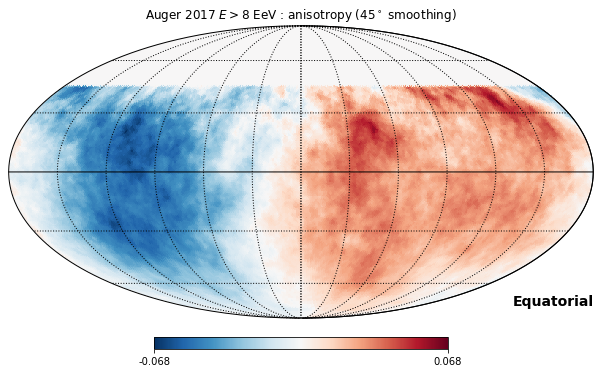

In [8]:
# anisotropy map for TOPHAT smoothing
mymax=max(np.amax(deltaI_healpy),-np.amin(deltaI_healpy))
digits = int(np.ceil(-np.log(mymax)/np.log(10)))+1
mymax = np.around(mymax, decimals=digits)

title = r'Auger 2017 $E>8$ EeV : anisotropy ($' + format(TOPHAT, '.0f') + r'^\circ$ smoothing)'

H.mollview(deltaI_healpy,title=title,coord='C',cbar=True,rot=180,cmap="RdBu_r",min=-mymax,max=mymax)
H.graticule()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


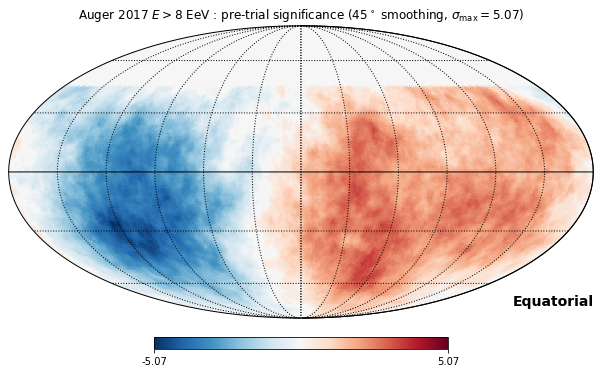

In [9]:
# significance map for TOPHAT smoothing
mymax=max(np.amax(pretrial_healpy),-np.amin(pretrial_healpy))
digits = int(np.ceil(-np.log(mymax)/np.log(10)))+2
mymax2 = np.around(mymax, decimals=digits)

title = r'Auger 2017 $E>8$ EeV : pre-trial significance ($' + format(TOPHAT, '.0f') + r'^\circ$ smoothing, $\sigma_{\rm max} = ' + format(mymax, '.2f') + '$)'

H.mollview(pretrial_healpy ,title=title,coord='C',cbar=True,rot=180,cmap="RdBu_r",min=-mymax2,max=mymax2)
H.graticule()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


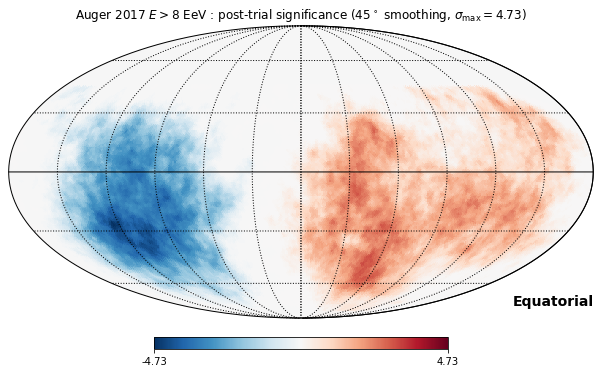

In [10]:
# trial-corrected significance map for TOPHAT smoothing
mymax=max(np.amax(posttrial_healpy),-np.amin(posttrial_healpy))	
digits = int(np.ceil(-np.log(mymax)/np.log(10)))+2
mymax2 = np.around(mymax, decimals=digits)

title = r'Auger 2017 $E>8$ EeV : post-trial significance ($' + format(TOPHAT, '.0f') + r'^\circ$ smoothing, $\sigma_{\rm max} = ' + format(mymax2, '.2f') + '$)'

H.mollview(posttrial_healpy ,title=title,coord='C',cbar=True,rot=180,cmap="RdBu_r",min=-mymax2,max=mymax2)
H.graticule()

In [11]:
# instead of allsky analysis, we can directly fit the equatorial dipole

#initialize
bestfit_dipole = CRAToPy.INA_Lambert(ndec,LATITUDE,THETAMAX)
bestfit_dipole.firstguess(CRmap)

#recursively fit the dipole
out = CRAToPy.extract_dipole_Lambert(CRmap,bestfit_dipole,NITER)

0 8.095281478114233
1 11.920369664977347
2 13.732107436336724
3 14.586297970540658
4 14.991601979280166
5 15.182453113572201
6 15.273202791243154
7 15.31587111214021
8 15.336223214568996
9 15.345766156871917
10 15.350344371649175
11 15.352479122997215
12 15.35351534280795
13 15.353992935312613
14 15.354230431072384
15 15.354337285154037
16 15.354393099819092
17 15.354417007501299
18 15.354430762823522
19 15.35443611205543
20 15.354439789503525
21 15.354440986383205


In [13]:
print("dipole fit summary:")
print('d0h = ' + format(out[0], '.4f') + ' +/- ' + format(out[1], '.4f'))
print('d6h = ' + format(out[2], '.4f') + ' +/- ' + format(out[3], '.4f'))
print('amplitude = ' + format(out[4], '.4f') + ' +/- ' + format(out[5], '.4f'))
print('bestfit RA phase = ' + format(out[6], '.2f') + ' +/- ' + format(out[7], '.2f') + 'deg')

dipole fit summary:
d0h = -0.0120 +/- 0.0132
d6h = 0.0510 +/- 0.0134
amplitude = 0.0524 +/- 0.0133
bestfit RA phase = 103.28 +/- 14.43deg
